In [5]:
# ==== Eval with per-model subdirs & per-example checkpointing ====
import json
from pathlib import Path
from tqdm.auto import tqdm
import torch

ROOT_DIR = '..'

# --- config ---
SPLIT = "train"
START_IDX = 0
N_EVAL = 10  # set to 5 if you want a quick smoke test

# Models must already be constructed (gpt / claude / gemini)
models = [
    ("gpt-5-mini", gpt),
    ("claude-3-5-sonnet-latest", claude),
    ("gemini-2.0-flash", gemini),
]

RESULTS_ROOT = Path(ROOT_DIR) / "results"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

def _is_valid_per_model_payload(obj: dict) -> bool:
    """Schema check for a saved per-example JSON (per-model)."""
    try:
        if not isinstance(obj, dict): return False
        if "index" not in obj: return False
        if "y_true" not in obj or not isinstance(obj["y_true"], list): return False
        if len(obj["y_true"]) != 12: return False
        if "y_pred" not in obj or not isinstance(obj["y_pred"], list): return False
        if len(obj["y_pred"]) != 12: return False
        if "qa_rows" not in obj or not isinstance(obj["qa_rows"], list): return False
        if len(obj["qa_rows"]) != 12: return False
        return True
    except Exception:
        return False

for model_name, model in models:
    print(f"\n=== Evaluating model: {model_name} ===")

    # Per-model paths
    MODEL_DIR = RESULTS_ROOT / model_name
    SAMPLES_DIR = MODEL_DIR / "cholecseg8k_samples"
    AGG_PATH = MODEL_DIR / "cholecseg8k.json"
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

    # Aggregate container for this model
    records = {
        "model": model_name,
        "dataset": "minwoosun/CholecSeg8k",
        "split": SPLIT,
        "n_eval": N_EVAL,
        "indices": [],
        "meta": {
            "label_ids": list(range(1, 13)),
            "id2label": ID2LABEL,
        },
        "examples": [],  # list of per-example dicts
    }

    for idx in tqdm(range(START_IDX, START_IDX + N_EVAL), desc=f"{model_name}"):
        ex_path = SAMPLES_DIR / f"{SPLIT}_{idx:05d}.json"

        # If exists and valid -> load & skip
        if ex_path.exists():
            try:
                with open(ex_path, "r") as f:
                    cached = json.load(f)
                if _is_valid_per_model_payload(cached):
                    records["indices"].append(idx)
                    records["examples"].append(cached)
                    continue
                else:
                    print(f"[info] Recomputing invalid file: {ex_path.name}")
            except Exception as e:
                print(f"[info] Could not load {ex_path.name} ({e}); recomputing.")

        # Compute from scratch for this model
        example = dataset[SPLIT][idx]
        try:
            img_t, lab_t = example_to_tensors(example)

            qa_rows, y_pred, y_true = vlm_presence_pipeline(model, img_t, lab_t)
            example_result = {
                "index": idx,
                "y_true": y_true.tolist(),
                "y_pred": y_pred.tolist(),
                "qa_rows": qa_rows,
            }

            # Save per-example immediately
            with open(ex_path, "w") as f:
                json.dump(example_result, f, indent=2)

            # Add to aggregate
            records["indices"].append(idx)
            records["examples"].append(example_result)

        except Exception as e:
            # Save a minimal error stub (will be recomputed next time)
            err_obj = {"index": idx, "error": str(e)}
            with open(ex_path, "w") as f:
                json.dump(err_obj, f, indent=2)
            print(f"[error] {model_name} idx={idx}: {e}")

    # Save aggregate file for this model
    with open(AGG_PATH, "w") as f:
        json.dump(records, f, indent=2)

    print(f"Per-example files: {SAMPLES_DIR}")
    print(f"Aggregate saved to: {AGG_PATH}")



=== Evaluating model: gpt-5-mini ===


gpt-5-mini:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results/gpt-5-mini/cholecseg8k_samples
Aggregate saved to: ../results/gpt-5-mini/cholecseg8k.json


In [6]:
# ==== Load per-example JSONs and report per-organ accuracy ====
from pathlib import Path
import json
import numpy as np

# If your utils are importable, use their mapping; else fall back.
try:
    from cholecseg8k_utils import ID2LABEL
except Exception:
    ID2LABEL = {
        0:"Black Background",1:"Abdominal Wall",2:"Liver",3:"Gastrointestinal Tract",
        4:"Fat",5:"Grasper",6:"Connective Tissue",7:"Blood",8:"Cystic Duct",
        9:"L-hook Electrocautery",10:"Gallbladder",11:"Hepatic Vein",12:"Liver Ligament"
    }

LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

def iter_example_jsons(root_dir: str, model_name: str, split: str = "train"):
    """
    Yields valid per-example result dicts for a given model.
    Skips files with errors or wrong schema.
    """
    sample_dir = Path(root_dir) / "results" / model_name / "cholecseg8k_samples"
    if not sample_dir.exists():
        raise FileNotFoundError(f"Missing dir: {sample_dir}")

    for p in sorted(sample_dir.glob(f"{split}_*.json")):
        try:
            with open(p, "r") as f:
                obj = json.load(f)
            if "error" in obj:
                continue
            if not isinstance(obj, dict):
                continue
            if "y_true" not in obj or "y_pred" not in obj:
                continue
            if not (isinstance(obj["y_true"], list) and isinstance(obj["y_pred"], list)):
                continue
            if len(obj["y_true"]) != len(LABEL_IDS) or len(obj["y_pred"]) != len(LABEL_IDS):
                continue
            yield obj
        except Exception:
            # Skip unreadable/corrupted file
            continue

def accuracy_per_organ(records):
    """
    records: iterable of dicts with keys y_true (len 12) and y_pred (len 12)
    returns: (rows, macro_acc, micro_acc, n_examples)
    """
    correct = np.zeros(len(LABEL_IDS), dtype=np.int64)
    total   = np.zeros(len(LABEL_IDS), dtype=np.int64)
    n_examples = 0

    for r in records:
        y_true = np.asarray(r["y_true"], dtype=int)
        y_pred = np.asarray(r["y_pred"], dtype=int)
        m = (y_true == y_pred).astype(np.int64)

        correct += m
        total   += 1  # one decision per organ per example
        n_examples += 1

    with np.errstate(divide="ignore", invalid="ignore"):
        acc = np.divide(correct, total, out=np.zeros_like(correct, dtype=float), where=total > 0)

    rows = []
    for i, cls_id in enumerate(LABEL_IDS):
        rows.append({
            "label_id": cls_id,
            "label": ID2LABEL[cls_id],
            "correct": int(correct[i]),
            "total":   int(total[i]),
            "accuracy": float(acc[i]),  # 0..1
        })

    macro = float(acc.mean()) if len(acc) else 0.0
    micro = float(correct.sum() / total.sum()) if total.sum() > 0 else 0.0
    return rows, macro, micro, n_examples

def print_model_report(model_name: str, root_dir: str = "..", split: str = "train"):
    recs = list(iter_example_jsons(root_dir, model_name, split))
    rows, macro, micro, n = accuracy_per_organ(recs)

    print(f"\nModel: {model_name} | Split: {split} | Examples used: {n}")
    for r in rows:
        print(f"{r['label_id']:>2}  {r['label']:<24}  {r['correct']:>4}/{r['total']:<4}  = {r['accuracy']*100:6.2f}%")
    print(f"Macro avg: {macro*100:6.2f}%   Micro avg: {micro*100:6.2f}%")

# ---- usage ----
ROOT_DIR = ".."
for model_name in ["gpt-5-mini", "claude-3-5-sonnet-latest", "gemini-2.0-flash"]:
    try:
        print_model_report(model_name, root_dir=ROOT_DIR, split="train")
    except FileNotFoundError as e:
        print(f"[skip] {e}")



Model: gpt-5-mini | Split: train | Examples used: 10
 1  Abdominal Wall              10/10    = 100.00%
 2  Liver                       10/10    = 100.00%
 3  Gastrointestinal Tract       9/10    =  90.00%
 4  Fat                         10/10    = 100.00%
 5  Grasper                     10/10    = 100.00%
 6  Connective Tissue            0/10    =   0.00%
 7  Blood                       10/10    = 100.00%
 8  Cystic Duct                  4/10    =  40.00%
 9  L-hook Electrocautery        8/10    =  80.00%
10  Gallbladder                  6/10    =  60.00%
11  Hepatic Vein                10/10    = 100.00%
12  Liver Ligament               4/10    =  40.00%
Macro avg:  75.83%   Micro avg:  75.83%
[skip] Missing dir: ../results/claude-3-5-sonnet-latest/cholecseg8k_samples
[skip] Missing dir: ../results/gemini-2.0-flash/cholecseg8k_samples


# Even split

In [12]:
# ==== Eval with per-model subdirs & per-example checkpointing (evenly spaced indices) ====
import json
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import torch

ROOT_DIR = '..'

# --- config ---
SPLIT = "train"
START_IDX = 0
N_EVAL = 10  # set to 5 if you want a quick smoke test

# Models must already be constructed (gpt / claude / gemini)
models = [
    ("gpt-5-mini", gpt),
    ("claude-3-5-sonnet-latest", claude),
    ("gemini-2.0-flash", gemini),
    ("claude-sonnet-4-20250514", claude),
    ("gemini-2.5-pro", gemini),
]

RESULTS_ROOT = Path(ROOT_DIR) / "results_10"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

def _is_valid_per_model_payload(obj: dict) -> bool:
    """Schema check for a saved per-example JSON (per-model)."""
    try:
        if not isinstance(obj, dict): return False
        if "index" not in obj: return False
        if "y_true" not in obj or not isinstance(obj["y_true"], list): return False
        if len(obj["y_true"]) != 12: return False
        if "y_pred" not in obj or not isinstance(obj["y_pred"], list): return False
        if len(obj["y_pred"]) != 12: return False
        if "qa_rows" not in obj or not isinstance(obj["qa_rows"], list): return False
        if len(obj["qa_rows"]) != 12: return False
        return True
    except Exception:
        return False

# ---- build evenly spaced indices over the split ----
TOTAL = len(dataset[SPLIT])
END_IDX = TOTAL - 1  # inclusive end
if N_EVAL > (END_IDX - START_IDX + 1):
    N_EVAL = END_IDX - START_IDX + 1

# linspace gives ~equal spacing: step ≈ (END_IDX - START_IDX) / N_EVAL
idxs = np.linspace(START_IDX, END_IDX, num=N_EVAL, dtype=int).tolist()

# dedupe while preserving order (linspace + int can collide for tiny ranges)
_seen, spaced_indices = set(), []
for i in idxs:
    if i not in _seen:
        spaced_indices.append(i)
        _seen.add(i)

print(f"Evaluating {len(spaced_indices)} evenly spaced indices from {START_IDX}..{END_IDX}")
# -----------------------------------------------

for model_name, model in models:
    print(f"\n=== Evaluating model: {model_name} ===")

    # Per-model paths
    MODEL_DIR = RESULTS_ROOT / model_name
    SAMPLES_DIR = MODEL_DIR / "cholecseg8k_samples"
    AGG_PATH = MODEL_DIR / "cholecseg8k.json"
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

    # Aggregate container for this model
    records = {
        "model": model_name,
        "dataset": "minwoosun/CholecSeg8k",
        "split": SPLIT,
        "n_eval": len(spaced_indices),
        "indices": [],
        "meta": {"label_ids": list(range(1, 13)), "id2label": ID2LABEL},
        "examples": [],  # list of per-example dicts
    }

    for idx in tqdm(spaced_indices, desc=f"{model_name}"):
        ex_path = SAMPLES_DIR / f"{SPLIT}_{idx:05d}.json"

        # If exists and valid -> load & skip
        if ex_path.exists():
            try:
                with open(ex_path, "r") as f:
                    cached = json.load(f)
                if _is_valid_per_model_payload(cached):
                    records["indices"].append(idx)
                    records["examples"].append(cached)
                    continue
                else:
                    print(f"[info] Recomputing invalid file: {ex_path.name}")
            except Exception as e:
                print(f"[info] Could not load {ex_path.name} ({e}); recomputing.")

        # Compute from scratch for this model
        example = dataset[SPLIT][idx]
        try:
            img_t, lab_t = example_to_tensors(example)

            # If you implemented a batched version, swap this call:
            # qa_rows, y_pred, y_true = run_batched_presence(model, img_t, lab_t)
            qa_rows, y_pred, y_true = vlm_presence_pipeline(model, img_t, lab_t)

            example_result = {
                "index": idx,
                "y_true": y_true.tolist(),
                "y_pred": y_pred.tolist(),
                "qa_rows": qa_rows,
            }

            # Save per-example immediately
            with open(ex_path, "w") as f:
                json.dump(example_result, f, indent=2)

            # Add to aggregate
            records["indices"].append(idx)
            records["examples"].append(example_result)

        except Exception as e:
            # Save a minimal error stub (will be recomputed next time)
            err_obj = {"index": idx, "error": str(e)}
            with open(ex_path, "w") as f:
                json.dump(err_obj, f, indent=2)
            print(f"[error] {model_name} idx={idx}: {e}")

    # Save aggregate file for this model
    with open(AGG_PATH, "w") as f:
        json.dump(records, f, indent=2)

    print(f"Per-example files: {SAMPLES_DIR}")
    print(f"Aggregate saved to: {AGG_PATH}")


Evaluating 10 evenly spaced indices from 0..8079

=== Evaluating model: gpt-5-mini ===


gpt-5-mini:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results_10/gpt-5-mini/cholecseg8k_samples
Aggregate saved to: ../results_10/gpt-5-mini/cholecseg8k.json

=== Evaluating model: claude-3-5-sonnet-latest ===


claude-3-5-sonnet-latest:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results_10/claude-3-5-sonnet-latest/cholecseg8k_samples
Aggregate saved to: ../results_10/claude-3-5-sonnet-latest/cholecseg8k.json

=== Evaluating model: gemini-2.0-flash ===


gemini-2.0-flash:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results_10/gemini-2.0-flash/cholecseg8k_samples
Aggregate saved to: ../results_10/gemini-2.0-flash/cholecseg8k.json

=== Evaluating model: claude-sonnet-4-20250514 ===


claude-sonnet-4-20250514:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results_10/claude-sonnet-4-20250514/cholecseg8k_samples
Aggregate saved to: ../results_10/claude-sonnet-4-20250514/cholecseg8k.json

=== Evaluating model: gemini-2.5-pro ===


gemini-2.5-pro:   0%|          | 0/10 [00:00<?, ?it/s]

Per-example files: ../results_10/gemini-2.5-pro/cholecseg8k_samples
Aggregate saved to: ../results_10/gemini-2.5-pro/cholecseg8k.json


In [14]:
# ==== Load per-example JSONs and report TP/FN/Present_n/TN/FP/Absent_n per organ ====
from pathlib import Path
import json
import numpy as np

# If your utils are importable, use their mapping; else fall back.
try:
    from cholecseg8k_utils import ID2LABEL
except Exception:
    ID2LABEL = {
        0:"Black Background",1:"Abdominal Wall",2:"Liver",3:"Gastrointestinal Tract",
        4:"Fat",5:"Grasper",6:"Connective Tissue",7:"Blood",8:"Cystic Duct",
        9:"L-hook Electrocautery",10:"Gallbladder",11:"Hepatic Vein",12:"Liver Ligament"
    }
LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

def iter_example_jsons(root_dir: str, model_name: str, split: str = "train",
                       results_dir_name: str = "results_10", samples_subdir: str = "cholecseg8k_samples"):
    """Yields valid per-example dicts for a given model (skips errors/partials)."""
    sample_dir = Path(root_dir) / results_dir_name / model_name / samples_subdir
    if not sample_dir.exists():
        raise FileNotFoundError(f"Missing dir: {sample_dir}")

    for p in sorted(sample_dir.glob(f"{split}_*.json")):
        try:
            with open(p, "r") as f:
                obj = json.load(f)
            if "error" in obj:
                continue
            if not isinstance(obj, dict):
                continue
            if "y_true" not in obj or "y_pred" not in obj:
                continue
            if not (isinstance(obj["y_true"], list) and isinstance(obj["y_pred"], list)):
                continue
            if len(obj["y_true"]) != len(LABEL_IDS) or len(obj["y_pred"]) != len(LABEL_IDS):
                continue
            yield obj
        except Exception:
            continue  # skip unreadable/corrupted

def confusion_per_organ(records):
    """
    records: iterable of dicts with keys y_true (len 12) and y_pred (len 12)
    returns: (rows, totals, n_examples)
      rows[i] = dict(label_id, label, tp, tn, fp, fn, present_n, absent_n, total_n)
      totals  = dict(tp, tn, fp, fn, present_n, absent_n, total)
    """
    K = len(LABEL_IDS)
    tp = np.zeros(K, dtype=np.int64)
    tn = np.zeros(K, dtype=np.int64)
    fp = np.zeros(K, dtype=np.int64)
    fn = np.zeros(K, dtype=np.int64)
    n_examples = 0

    for r in records:
        y_true = np.asarray(r["y_true"], dtype=int)
        y_pred = np.asarray(r["y_pred"], dtype=int)
        tp += ((y_true == 1) & (y_pred == 1)).astype(np.int64)
        tn += ((y_true == 0) & (y_pred == 0)).astype(np.int64)
        fp += ((y_true == 0) & (y_pred == 1)).astype(np.int64)
        fn += ((y_true == 1) & (y_pred == 0)).astype(np.int64)
        n_examples += 1

    present_n = tp + fn
    absent_n  = tn + fp
    total_n   = present_n + absent_n

    rows = []
    for i, cls_id in enumerate(LABEL_IDS):
        rows.append({
            "label_id": cls_id,
            "label": ID2LABEL[cls_id],
            "tp": int(tp[i]),
            "fn": int(fn[i]),
            "present_n": int(present_n[i]),
            "tn": int(tn[i]),
            "fp": int(fp[i]),
            "absent_n": int(absent_n[i]),
            "total_n": int(total_n[i]),
        })

    totals = {
        "tp": int(tp.sum()),
        "fn": int(fn.sum()),
        "present_n": int(present_n.sum()),
        "tn": int(tn.sum()),
        "fp": int(fp.sum()),
        "absent_n": int(absent_n.sum()),
        "total": int(total_n.sum()),
    }
    return rows, totals, n_examples

def print_model_confusion(model_name: str, root_dir: str = "..", split: str = "train",
                          results_dir_name: str = "results_10", samples_subdir: str = "cholecseg8k_samples"):
    recs = list(iter_example_jsons(root_dir, model_name, split, results_dir_name, samples_subdir))
    rows, totals, n = confusion_per_organ(recs)

    print(f"\nModel: {model_name} | Split: {split} | Examples used: {n}")
    print("ID  Label                     TP    FN   Present  TN    FP   Absent  Total")
    for r in rows:
        print(f"{r['label_id']:>2}  {r['label']:<24}  "
              f"{r['tp']:>4}  {r['fn']:>4}   {r['present_n']:>7}  "
              f"{r['tn']:>4}  {r['fp']:>4}   {r['absent_n']:>6}  {r['total_n']:>5}")
    print("\nTotals across organs:")
    print(f"TP={totals['tp']}  FN={totals['fn']}  Present={totals['present_n']}  "
          f"TN={totals['tn']}  FP={totals['fp']}  Absent={totals['absent_n']}  Total={totals['total']}")

# ---- usage ----
ROOT_DIR = ".."
for model_name in ["gpt-5-mini", "claude-3-5-sonnet-latest", "gemini-2.0-flash", "claude-sonnet-4-20250514", "gemini-2.5-pro"]:
    try:
        print_model_confusion(model_name, root_dir=ROOT_DIR, split="train",
                              results_dir_name="results_10", samples_subdir="cholecseg8k_samples")
    except FileNotFoundError as e:
        print(f"[skip] {e}")



Model: gpt-5-mini | Split: train | Examples used: 10
ID  Label                     TP    FN   Present  TN    FP   Absent  Total
 1  Abdominal Wall               7     2         9     1     0        1     10
 2  Liver                       10     0        10     0     0        0     10
 3  Gastrointestinal Tract       3     3         6     3     1        4     10
 4  Fat                         10     0        10     0     0        0     10
 5  Grasper                      7     0         7     2     1        3     10
 6  Connective Tissue            1     0         1     0     9        9     10
 7  Blood                        0     0         0     7     3       10     10
 8  Cystic Duct                  0     0         0     5     5       10     10
 9  L-hook Electrocautery        0     0         0     4     6       10     10
10  Gallbladder                  6     2         8     1     1        2     10
11  Hepatic Vein                 0     1         1     9     0        9     10
12

In [17]:
import os
ROOT_DIR = ".."

import json
with open(f"{ROOT_DIR}/API_KEYS2.json", "r") as file:
    api_keys = json.load(file)

os.environ['OPENAI_API_KEY'] = api_keys['OPENAI_API_KEY']
os.environ['ANTHROPIC_API_KEY'] = api_keys['ANTHROPIC_API_KEY']
os.environ['GOOGLE_API_KEY'] = api_keys['GOOGLE_API_KEY']
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir3')

In [105]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import json

import sys; sys.path.append("../src")
import llms
import cholec
import cholecseg8k_utils
from importlib import reload
reload(cholec)
reload(cholecseg8k_utils)
reload(llms)
from cholec import CholecExample, CholecDataset, load_model, items_to_examples
from cholecseg8k_utils import ID2LABEL, LABEL2ID, display_image, example_to_tensors, presence_qas_from_example
from llms import MyOpenAIModel, MyAnthropicModel, MyGoogleModel

In [82]:
# gpt = load_model("gpt-4o")
gpt = load_model("gpt-5-mini")
claude = load_model("claude-3-5-sonnet-latest")
gemini = load_model("gemini-2.0-flash")

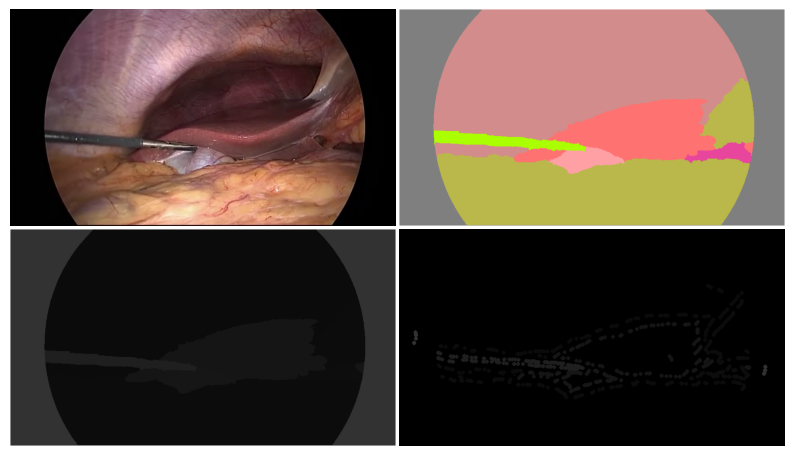

In [83]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("minwoosun/CholecSeg8k")

display_image(dataset, 800) # video index from 0 to 8079


In [ ]:
import os, json
from pathlib import Path
from tqdm.auto import tqdm
import torch

# -------- settings --------
OUT_DIR = Path(ROOT) / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "cholecseg8k.json"

N_EVAL = 50
SPLIT = "train"
START_IDX = 0  # change if you want a different slice

# -------- sanity checks --------
assert 'gpt' in globals() and 'claude' in globals() and 'gemini' in globals(), \
    "Please define `gpt`, `claude`, and `gemini` via load_model(...) before running."

# -------- run evaluation --------
records = {
    "dataset": "minwoosun/CholecSeg8k",
    "split": SPLIT,
    "n_eval": N_EVAL,
    "indices": [],
    "meta": {
        "label_ids": list(range(1, 13)),
        "id2label": ID2LABEL,
    },
    "examples": []  # one entry per image
}

models = [
    ("gpt-5-mini", gpt),
    ("claude-3-5-sonnet-latest", claude),
    ("gemini-2.0-flash", gemini),
]

for idx in tqdm(range(START_IDX, START_IDX + N_EVAL), desc="Evaluating"):
    example = dataset[SPLIT][idx]
    try:
        img_t, lab_t = example_to_tensors(example)
        example_result = {
            "index": idx,
            # We'll fill y_true from the first model run and verify it matches others
            "y_true": None,
            "per_model": {}
        }

        y_true_ref = None
        for model_name, model in models:
            qa_rows, y_pred, y_true = vlm_presence_pipeline(model, img_t, lab_t)

            if y_true_ref is None:
                y_true_ref = y_true.clone()
                example_result["y_true"] = y_true_ref.tolist()
            else:
                # guard (should be identical for all models)
                if not torch.equal(y_true_ref, y_true):
                    print(f"[warn] y_true mismatch at index {idx} for model {model_name}")

            example_result["per_model"][model_name] = {
                "y_pred": y_pred.tolist(),   # 12-length 0/1
                "qa_rows": qa_rows           # list of 12 dicts
            }

        records["indices"].append(idx)
        records["examples"].append(example_result)

    except Exception as e:
        # Keep going on errors; record the failure for this index
        records["indices"].append(idx)
        records["examples"].append({
            "index": idx,
            "error": str(e)
        })
        continue

# -------- save --------
with open(OUT_PATH, "w") as f:
    json.dump(records, f, indent=2)

print(f"Saved results to: {OUT_PATH}")


In [84]:
# --- example usage ---
from datasets import load_dataset
dataset = load_dataset("minwoosun/CholecSeg8k")
img_t, lab_t = example_to_tensors(dataset['train'][800])
print(img_t.shape, img_t.dtype, img_t.min().item(), img_t.max().item())
print(lab_t.shape, lab_t.dtype, torch.unique(lab_t)[:10])


torch.Size([3, 480, 854]) torch.float32 0.0 1.0
torch.Size([480, 854]) torch.int64 tensor([-1,  0,  1,  2,  3,  4,  5, 10])


In [85]:
import torch
import numpy as np


{'label_id': 1, 'label': 'Abdominal Wall', 'question': 'Is Abdominal Wall in the image?', 'answer': 1, 'count': 156452}
torch.Size([12]) tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0])


In [106]:
# ======= VLM presence Q/A pipeline (single-word Yes/No) =======

import re
import torch
import numpy as np
from typing import Callable, List, Tuple, Dict
from torchvision.transforms.functional import to_pil_image

# ---- class maps ----
ID2LABEL = {
    0: "Black Background",
    1: "Abdominal Wall",
    2: "Liver",
    3: "Gastrointestinal Tract",
    4: "Fat",
    5: "Grasper",
    6: "Connective Tissue",
    7: "Blood",
    8: "Cystic Duct",
    9: "L-hook Electrocautery",
    10: "Gallbladder",
    11: "Hepatic Vein",
    12: "Liver Ligament",
}
LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

# ---- ground-truth presence from label map ----
def labels_to_presence_vector(lab_t: torch.Tensor,
                              ignore_index: int = -1,
                              min_pixels: int = 1) -> torch.LongTensor:
    """
    Returns y [12] with 0/1 presence for class IDs 1..12 (excludes 0).
    """
    if isinstance(lab_t, np.ndarray):
        lab_t = torch.from_numpy(lab_t)
    lab_t = lab_t.to(torch.long)

    valid = lab_t != ignore_index
    flat = lab_t[valid].view(-1)
    num_classes = max(ID2LABEL.keys()) + 1  # 13
    counts = torch.zeros(num_classes, dtype=torch.long)
    if flat.numel() > 0:
        counts = torch.bincount(flat, minlength=num_classes)
    y = (counts[LABEL_IDS] >= min_pixels).to(torch.long)  # [12]
    return y

# ---- prompt builders ----
def build_system_prompt() -> str:
    return (
        "You are a surgical vision validator. You will be shown one laparoscopic image.\n"
        "Answer STRICTLY with a single word: Yes or No.\n"
        "Rules:\n"
        "- 'Yes' only if ANY visible part of the named structure is present in the image.\n"
        "- If uncertain/occluded/blurred, answer 'No'.\n"
        "- Do not include punctuation, explanation, JSON, or extra words.\n"
    )

def build_user_prompt(organ_name: str) -> str:
    return f"Question: Is {organ_name} visible in the image?\nAnswer:"

# ---- output sanitizer (forces a single Yes/No) ----
YESNO_RE = re.compile(r"\b(yes|no)\b", re.IGNORECASE)

def to_yes_no(raw_text: str) -> str:
    """Extract a single 'Yes' or 'No' from model output (fallback: 'No')."""
    if not isinstance(raw_text, str):
        return "No"
    m = YESNO_RE.search(raw_text.strip())
    if not m:
        return "No"
    return "Yes" if m.group(1).lower() == "yes" else "No"

# ---- VLM call wrapper ----
def ask_vlm_yes_no(
    model: Callable[..., str],   # e.g., gpt/claude/gemini instance
    img_t: torch.Tensor,
    organ_name: str,
    *,
    reprompt_once: bool = True,
) -> str:
    """
    Calls your VLM exactly once per organ and returns 'Yes' or 'No'.
    The model must support: model(prompt_or_tuple, system_prompt=...).
    """
    # Torch [3,H,W] -> PIL
    pil_img = to_pil_image(img_t.clamp(0, 1))
    system = build_system_prompt()
    user = build_user_prompt(organ_name)

    # First try
    out = model((pil_img, user), system_prompt=system)
    ans = to_yes_no(out)

    # Optional reprompt if invalid
    if reprompt_once and ans not in ("Yes", "No"):
        stricter = (
            system
            + "\nAnswer with exactly one token: Yes or No. "
              "Do not include any other characters."
        )
        out2 = model((pil_img, user), system_prompt=stricter)
        ans = to_yes_no(out2)

    return ans if ans in ("Yes", "No") else "No"

# ---- full pipeline for one example ----
def vlm_presence_pipeline(
    model: Callable[..., str],
    img_t: torch.Tensor,
    lab_t: torch.Tensor,
    *,
    ignore_index: int = -1,
    min_pixels: int = 1,
) -> Tuple[List[Dict], torch.LongTensor, torch.LongTensor]:
    """
    Runs 12 Yes/No queries (IDs 1..12).
    Returns:
      qa_rows: list of dicts with {'label_id','label','question','prediction','gt'}
      y_pred: torch.LongTensor [12] (0/1)
      y_true: torch.LongTensor [12] (0/1)
    """
    y_true = labels_to_presence_vector(lab_t, ignore_index, min_pixels)   # [12]
    y_pred_list = []
    qa_rows = []

    for idx, cls_id in enumerate(LABEL_IDS):
        label = ID2LABEL[cls_id]
        pred = ask_vlm_yes_no(model, img_t, label)  # 'Yes'/'No'
        pred01 = 1 if pred == "Yes" else 0
        y_pred_list.append(pred01)

        qa_rows.append({
            "label_id": cls_id,
            "label": label,
            "question": f"Is {label} visible in the image?",
            "prediction": pred,
            "gt": int(y_true[idx].item()),
        })

    y_pred = torch.tensor(y_pred_list, dtype=torch.long)   # [12]
    return qa_rows, y_pred, y_true

# ---- example usage ----
gpt    = load_model("gpt-5-mini")                  # or "gpt-4o"
claude = load_model("claude-3-5-sonnet-latest")
gemini = load_model("gemini-2.0-flash")

qa_rows, y_pred, y_true = vlm_presence_pipeline(gpt, img_t, lab_t)
print(qa_rows[0])
print("pred:", y_pred.tolist())
print("true:", y_true.tolist())

# You can swap in any model instance:
qa_rows_c, y_pred_c, y_true_c = vlm_presence_pipeline(claude, img_t, lab_t)
qa_rows_g, y_pred_g, y_true_g = vlm_presence_pipeline(gemini, img_t, lab_t)


{'label_id': 1, 'label': 'Abdominal Wall', 'question': 'Is Abdominal Wall visible in the image?', 'prediction': 'Yes', 'gt': 1}
pred: [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]
true: [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]


In [95]:
system_prompt = """You are a surgical vision validator. You will be shown one laparoscopic image.
Answer STRICTLY in compact JSON. No prose, no extra keys, no trailing commas.
Schema:
{"organ":"<name>", "present": 0|1, "confidence": 0.00-1.00, "evidence": "<<=12 words>"}
Rules:
- “present” = 1 if ANY visible part of the organ appears; else 0.
- If uncertain/occluded/blurred, set present=0 and confidence≤0.40.
- Do not infer outside the field of view. Do not mention tools unless they are cues.
"""

user_prompt = """Organ definition and cues:

Organ: Abdominal Wall
Positive cues: peritoneal/abdominal lining near trocar entry; inner surface of the anterior abdominal wall; visible mesh of vessels on pale pink tissue at the periphery; camera at port site showing fascia/peritoneum.
Common confusions: yellow lobulated omentum/fat (label as Fat), smooth dark-brown parenchyma (Liver), white/metal/plastic is instrument, not wall.
Negative cues: only intra-abdominal organs (liver, GB, ducts) with no peritoneal/port view.

Now answer for this image:
"""

In [99]:
from tqdm.auto import tqdm
preds = []
labels = []
for di in tqdm(range(5)):
    preds_curr = []
    labels_curr = []
    
    # --- example usage ---
    img_t, lab_t = example_to_tensors(dataset['train'][di])  # from your previous helper
    qas, y = presence_qas_from_example(img_t, lab_t)
    # print(qas[0])        # one QA dict
    # print(y.shape, y)    # tensor of length 12 with 0/1s in order of IDs 1..12

    for i in range(len(qas)):
        gen = gpt((img_t, system_prompt, user_prompt, qas[0]['question'], 'Please only return one of the following: <Yes/No>'))
        pred = gen == "Yes"
        print(gen)
        preds.append(pred)
        preds_curr.append(pred)
        labels_curr.append(i in torch.unique(lab_t))
        labels.append(i in torch.unique(lab_t))
    print('preds_curr', preds_curr)
    print('labels_curr', labels_curr)

  0%|          | 0/5 [00:00<?, ?it/s]

{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdominal Wall","present":1,"confidence":0.88,"evidence":"pale pink peritoneum with vascular mesh at periphery"}
{"organ":"Abdomi

KeyboardInterrupt: 

In [89]:
qas

[{'label_id': 1,
  'label': 'Abdominal Wall',
  'question': 'Is Abdominal Wall in the image?',
  'answer': 1,
  'count': 156452},
 {'label_id': 2,
  'label': 'Liver',
  'question': 'Is Liver in the image?',
  'answer': 1,
  'count': 35573},
 {'label_id': 3,
  'label': 'Gastrointestinal Tract',
  'question': 'Is Gastrointestinal Tract in the image?',
  'answer': 1,
  'count': 3664},
 {'label_id': 4,
  'label': 'Fat',
  'question': 'Is Fat in the image?',
  'answer': 1,
  'count': 102516},
 {'label_id': 5,
  'label': 'Grasper',
  'question': 'Is Grasper in the image?',
  'answer': 1,
  'count': 7386},
 {'label_id': 6,
  'label': 'Connective Tissue',
  'question': 'Is Connective Tissue in the image?',
  'answer': 0,
  'count': 0},
 {'label_id': 7,
  'label': 'Blood',
  'question': 'Is Blood in the image?',
  'answer': 0,
  'count': 0},
 {'label_id': 8,
  'label': 'Cystic Duct',
  'question': 'Is Cystic Duct in the image?',
  'answer': 0,
  'count': 0},
 {'label_id': 9,
  'label': 'L-hook 